In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import imageio
import os
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [13]:

brain_cancer_path = 'mcc2'


In [14]:
directories = []
for directory in os.listdir(brain_cancer_path):
    directories.append(directory)
print('Classes Present : ',list(directories))


Classes Present :  ['brain_menin', 'oral_scc', 'oral_normal', 'brain_glioma', 'brain_tumor']


In [15]:
all_pre_files=[]
all_early_files = []
oral_scc_files = []
all_benign_files = []
oral_normal_files = []
all_pro_files = []
brain_glioma_files = []
brain_tumor_files = []
for directory in directories:
    for files in os.listdir(os.path.join(brain_cancer_path,directory)):
        if directory == 'brain_menin':
            all_pre_files.append(os.path.join(brain_cancer_path,'brain_menin',files))
        elif directory == 'oral_normal':
            all_early_files.append(os.path.join(brain_cancer_path,'oral_normal',files))
        elif directory == 'oral_scc':
            oral_scc_files.append(os.path.join(brain_cancer_path,'oral_scc',files))
        elif directory == 'brain_glioma':
            brain_glioma_files.append(os.path.join(brain_cancer_path,'brain_glioma',files))
        elif directory == 'brain_tumor':
            brain_tumor_files.append(os.path.join(brain_cancer_path,'brain_tumor',files))
       


In [16]:
print('Total all_pre_files : ',len(all_pre_files))
print('Total all_early_files : ',len(all_early_files))
print('Total oral_scc_files : ',len(oral_scc_files))


Total all_pre_files :  5000
Total all_early_files :  5001
Total oral_scc_files :  5001


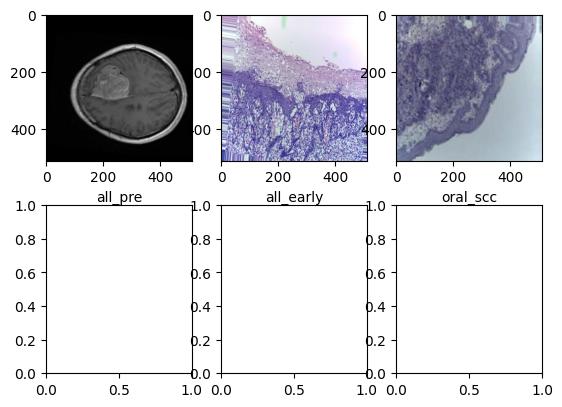

In [17]:

random_num = random.randint(0,len(all_pre_files))
brain_tumor_pic = all_pre_files[random_num]
brain_early_pic = all_early_files[random_num]
oral_scc_pic = oral_scc_files[random_num]
brain_tumor_data = imageio.imread(brain_tumor_pic)
brain_early_data = imageio.imread(brain_early_pic)
oral_scc_data = imageio.imread(oral_scc_pic)
fig,axs = plt.subplots(2,3)
axs[0,0].imshow(brain_tumor_data)
axs[0,1].imshow(brain_early_data)
axs[0,2].imshow(oral_scc_data)
axs[0,0].set_xlabel('all_pre')
axs[0,1].set_xlabel('all_early')
axs[0,2].set_xlabel('oral_scc')
plt.show()

In [18]:

gc.collect()


13313

In [19]:

generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    # shuffle=True
)


In [20]:
train_ds = generator.flow_from_directory(
    'mcc2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_ds = generator.flow_from_directory(
    'mcc2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 20002 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [21]:

checkpoint_filepath = 'checkpoint_small'
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
]


In [22]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5   , activation='softmax')(x)
model = Model(inputs=base_model_resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
history = model.fit(train_ds,verbose = 1,epochs = 1,batch_size = 32,validation_data = val_ds,callbacks = callback)

2023-11-02 19:11:39.218373: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-11-02 19:11:39.295192: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-11-02 19:11:39.335317: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2023-11-02 19:11:39.381269: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-11-02 19:11:39.423683: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


626/626 [==============================] - 1208s 2s/step - loss: 0.3118 - accuracy: 0.8685 - val_loss: 0.2060 - val_accuracy: 0.9148 - lr: 0.0010


In [24]:
model.save('mcc3.h5')